<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right" />

<h1 align=left><font size=8><b>Inteligência Artificial</b></font></h1>
<h1 align=left><font size=6><b>Deep Learning</b></font></h1>

# Atividade: T6 - Atividade de aprofundamento

Nome: Bruno Rebocho de Toledo

Turma: 01B

Matrícula: 92316328

---
## Introdução

Este notebook tem como objetivo explorar as capacidades de classificação de redes neurais com PyTorch.

---
## Dataset "Predict students' dropout and academic success"[1]

O conjunto de dados escolhido, criado a partir de uma instituição de ensino superior (adquirido de várias bases de dados independentes), descreve estudantes matriculados em diferentes graduações, como agronomia, design, educação, enfermagem, jornalismo, gestão, serviço social e tecnologias. O conjunto de dados inclui informações conhecidas no momento da matrícula do estudante (trajetória acadêmica, demografia e fatores socioeconômicos) e o desempenho acadêmico dos alunos ao final do primeiro e segundo semestres. Os dados são usados para construir modelos de classificação para prever a evasão e o sucesso acadêmico.

---
## O Problema

O problema é formulado como uma tarefa de classificação binária indicando a conclusão ou desistência do curso, na qual existe um forte desequilíbrio em favor de uma das classes originais.

## Uso de GPU

Iniciamos configurando nosso ambiente de execução para utilizar a GPU, caso disponível. As operações a serem executadas no treinamento deste modelo tendem a serem feitas de maneira muito mais rápida e eficiente em GPUs, devido à natureza da arquitetura deste tipo de chip e as estruturas dos dados aos quais iremos operar.

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


---
## Explorando os Dados

Inicialmente, começamos explorando os dados ao importar as bibliotecas `numpy` e `pandas`. Utilizamos o `pandas` para ler o arquivo 'data.csv', especificando o ponto e vírgula como delimitador.

Após a leitura do arquivo, exibimos as primeiras cinco linhas do DataFrame `df` com a função `head()`. Esta visualização inicial nos fornece uma visão rápida de como os dados estão estruturados, incluindo nomes de colunas e tipos de dados, o que é crucial para o planejamento das etapas seguintes de análise.

Em seguida, imprimimos a dimensão do DataFrame com `df.shape`, revelando o número total de linhas e colunas. Esta informação é fundamental para entender o volume e a complexidade dos dados com os quais estamos trabalhando, orientando as decisões sobre o processamento e a análise subsequente.

Por vim, verificamos a presença de nulos ou valores ausentes, o que não é o caso deste nosso conjunto de dados.

In [3]:
import numpy as np
import pandas as pd

!wget -O data.csv 'https://drive.google.com/uc?export=download&id=1hnHg7IN3qTPnIui2XrkT5hUd9XFH8Ecn'

df = pd.read_csv('data.csv', delimiter=';')

display(df.head())

print(df.shape)

--2023-11-25 23:10:58--  https://drive.google.com/uc?export=download&id=1hnHg7IN3qTPnIui2XrkT5hUd9XFH8Ecn
Resolving drive.google.com (drive.google.com)... 142.250.219.142, 2800:3f0:4001:823::200e
Connecting to drive.google.com (drive.google.com)|142.250.219.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n7fds8i7sdqppoojkmd00ol85do17h30/1700964375000/04037409333778562145/*/1hnHg7IN3qTPnIui2XrkT5hUd9XFH8Ecn?e=download&uuid=b5241756-c5c7-4d57-ad0e-89dbe38c8fa5 [following]
--2023-11-25 23:10:59--  https://doc-00-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n7fds8i7sdqppoojkmd00ol85do17h30/1700964375000/04037409333778562145/*/1hnHg7IN3qTPnIui2XrkT5hUd9XFH8Ecn?e=download&uuid=b5241756-c5c7-4d57-ad0e-89dbe38c8fa5
Resolving doc-00-9c-docs.googleusercontent.com (doc-00-9c-docs.googleusercontent.com)... 142.251.129.97, 2800:3f0:4001:8

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


(4424, 37)


In [4]:
df.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

#### Avaliando a Distribuição da Coluna Alvo

Prosseguindo com a exploração dos dados, focamos na coluna 'Target', que desempenha um papel crucial na nossa análise. Para entender melhor a distribuição dos valores nesta coluna, utilizamos o método `value_counts()` do Pandas. Este método nos retorna rapidamente um panorama da frequência de cada valor único na coluna 'Target'.

Ao realizar esta operação, estamos buscando informações sobre a distribuição das classes ou categorias representadas na coluna 'Target'. Esta informação é vital, pois uma distribuição desigual das classes pode influenciar significativamente o desempenho do modelo.

Assim, ao imprimir o resultado de `value_counts()`, estabelecemos uma base para compreender como os dados estão estruturados em relação à variável que pretendemos prever.

Como esperado, há um forte desbalanceamento entre os valores.

In [5]:
print(df['Target'].value_counts())

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


---
## Preparação dos Dados para Modelagem

Como estamos trabalhando com PyTorch, é boa prática criar uma classe customizada que extende a classe Dataset. Definimos um construtor com os parâmetros `X` e `y` a serem informados externamente. Esta abordagem foi escolhida pois facilita a normalização dos dados fora do contexto desta classe e simplifica sua reutilização.

Os métodos `__len__` e `__getitem__` também foram implementados pois são necessários para trabalhar em conjunto com o `DataLoader`.

Com o objetivo de adaptar nosso conjunto de dados para um problema de classificação binária, fizemos ajustes focando nas categorias 'Graduate' e 'Dropout'. Criamos a nova coluna 'Dropout' no DataFrame, codificando 'Graduate' como 0 e 'Dropout' como 1, que será nossa variável dependente. Eliminamos a categoria 'Enrolled', o que também contribui para reduzir o desbalanceamento inicial das classes.

Com a nova organização dos dados, removemos a coluna 'Target', pois ela já foi codificada em 'Dropout'. Em seguida, separamos o DataFrame em variáveis independentes `X` e a variável dependente `y`, que agora reflete com precisão o nosso problema binário de prever se um aluno irá se formar ou desistir.

In [6]:
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, X, y):
        self.X = X
        self.y = y

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

df = df[df['Target'].isin(['Graduate', 'Dropout'])]
df['Dropout'] = [0 if typ == 'Graduate' else 1 for typ in df['Target']]
df.drop(['Target'], axis=1, inplace=True)

X = df.values[:, :-1].astype('float32')
y = LabelEncoder().fit_transform(df.values[:, -1]).astype('float32').reshape((-1, 1))

---
## Separando os Dados em Treinamento e Teste

Agora avançamos para  a divisão do conjunto de dados em partes para treinamento e teste. Ao definirmos o parâmetro `test_size` como 0.3, estamos especificando que 30% do conjunto de dados será reservado para teste e 70% para treinar o modelo, conforme solicitado.

Após a aplicação da `train_test_split`, obtemos quatro conjuntos de dados: `X_train` e `y_train`, utilizados para treinamento, e `X_test` e `y_test`, que servirão para testar o modelo após o treinamento.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

---
## Normalizando os Dados

Iniciamos este processo utilizando o método `describe()` do DataFrame, que fornece um resumo estatístico, como média, desvio padrão, valores mínimos e máximos. Esta visão permite identificar a necessidade de normalização.

In [8]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Dropout
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,...,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,1.184298,18.421763,1.750138,8853.980992,0.887603,4.532231,132.920606,1.828099,19.986226,22.571625,...,0.581818,6.296419,7.763085,4.518457,10.036155,0.142149,11.630358,1.231598,-0.009256,0.391460
std,0.613009,17.358595,1.333831,2068.760082,0.315897,10.024134,13.238373,6.667614,15.585278,15.275453,...,2.022688,2.263020,3.964163,3.162376,5.481742,0.747670,2.667652,1.384911,2.259986,0.488144
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,5.000000,6.000000,2.000000,10.517857,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,1.400000,0.320000,0.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000,1.000000
max,6.000000,57.000000,6.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,1.000000


---
## Redução de Dimensionalidade e Pipeline de Pré-processamento

Neste estágio, aprimoramos o pré-processamento de dados incorporando a Análise de Componentes Principais (PCA). Começamos inicialmente com a importação e configuração do PCA da biblioteca `sklearn.decomposition`, definindo-o para reter 80% da variância dos dados.

No conjunto de treinamento (`X_train`), usamos o método `fit_transform` para ajustar o pipeline aos dados e, simultaneamente, transformá-los. O resultado dessa transformação é armazenado em `X_train_pca`. Para o conjunto de teste (`X_test`), empregamos o método `transform` para aplicar as mesmas transformações com os parâmetros ajustados durante o treinamento. Isso resulta em `X_test_pca`.

Em seguida, criamos duas instâncias de `CSVDataset`, uma para o conjunto de treinamento e outra para o conjunto de testes.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()

pca = PCA(n_components=0.8)

pipeline = make_pipeline(scaler, pca)

X_train_pca = pipeline.fit_transform(X_train)

X_test_pca = pipeline.transform(X_test)

# Criar datasets PyTorch
train_dataset = CSVDataset(X_train_pca, y_train)
test_dataset = CSVDataset(X_test_pca, y_test)

In [10]:
train_dataset.X, test_dataset.X

(array([[-5.8463993 , -1.3790396 , -2.874898  , ...,  0.55818516,
          0.22826365, -0.78947836],
        [ 0.20774123, -0.99490434,  0.40077075, ...,  0.34805715,
          0.96106744,  0.92383415],
        [-3.1222608 ,  3.0898252 ,  0.6123304 , ..., -1.860487  ,
         -0.4627076 ,  1.7729449 ],
        ...,
        [10.022979  ,  4.817454  , -0.83692676, ..., -0.5847175 ,
         -0.56172353, -0.96178216],
        [-3.018208  ,  2.0435925 , -1.5123434 , ...,  0.72649616,
         -1.0889461 , -0.19448298],
        [ 4.4777427 ,  2.9810402 ,  0.21792802, ...,  0.50901514,
          0.66408956,  0.10984462]], dtype=float32),
 array([[-5.909563  , -0.5748297 , -1.1094755 , ..., -0.18576607,
         -0.4978487 , -2.4878583 ],
        [-0.93038744,  2.7006207 , -1.2350564 , ..., -0.04033089,
          0.36496687, -0.21110648],
        [-0.5456989 , -0.60585105, -0.9633789 , ...,  0.9023639 ,
         -1.0695124 , -1.1092471 ],
        ...,
        [-0.14632176, -1.0091321 , -0.9

## Aplicação do DataLoader

A utilização de um `DataLoader` é boa prática para o treinamento de modelos de redes neurais com PyTorch. Ele encapsula o gerenciamento dos dados e permite customizações sob demanda.

Definimos um `DataLoader` para o nosso conjunto de dados de testes. O tamanho do batch foi definido em 32. Decidimos por ativar o embaralhamento (`shuffle=True`) pois este pode ser benéfico ao treinamento, evitando que o modelo memorize a ordem dos dados. Se os dados não forem embaralhados, o modelo pode 'aprender' a predizer o próximo batch baseado na ordem dos dados, ao invés de fato aprender com os padrões presentes nestes dados [3].



In [11]:
from torch.utils.data import DataLoader

train = DataLoader(train_dataset, batch_size=32, shuffle=True)

---
## Definindo o Modelo de Rede Neural

Determinamos o número de características de entrada (`n_inputs`) com base na forma do conjunto de dados de teste processado pelo PCA. Esse número guia a configuração da primeira camada da rede.

O modelo é construído como uma sequência de camadas, cada uma com a função de ativação `relu`, exceto a última camada que utiliza `sigmoid`. A primeira camada recebe `shape` neurônios, correspondendo ao número de características de entrada. A segunda camada tem metade do número de neurônios da primeira, seguindo uma estrutura que gradualmente condensa a informação. A última camada, com um único neurônio e ativação `sigmoid`, é adequada para uma tarefa de classificação binária, produzindo uma saída entre 0 e 1.

A função de perda escolhida foi a `BCELoss` (Binary Cross Entropy Loss) e o optimizador `Adam`, ambos adequados para a proposta de classificação binária.

In [12]:
from torch.optim import SGD, Adam
import torch.nn as nn

class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()

        self.hidden1 = nn.Linear(n_inputs, 8)
        self.act1 = nn.ReLU()

        self.hidden2 = nn.Linear(8, 4)
        self.act2 = nn.ReLU()

        self.hidden3 = nn.Linear(4, 1)
        self.act3 = nn.Sigmoid()

    # forward
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)

        X = self.hidden2(X)
        X = self.act2(X)

        X = self.hidden3(X)
        X = self.act3(X)

        return X

model = MLP(train_dataset.X.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

print(model)

MLP(
  (hidden1): Linear(in_features=16, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=4, out_features=1, bias=True)
  (act3): Sigmoid()
)


## Treinamento do Modelo

Configuramos um total de 10 iterações no treinamento do modelo. Este valor foi definido empiricamente.

Ao final do treinamento, o histórico é armazenado em uma variável acessória. Este histórico contém informações valiosas sobre a evolução da função de perda ao longo das épocas, permitindo a análise posterior do desempenho do modelo.

In [13]:
import numpy as np

EPOCHS = 10
loss_list = np.zeros((EPOCHS,))

for epoch in range(EPOCHS):
    loss_batch = 0

    for x_batch, y_batch in train:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # compute the model output
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss_batch + loss.item()

    loss_list[epoch] = loss_batch / len(x_batch)

---
## Curva de Aprendizado e Avaliação do Desempenho do Modelo

Depois o treinamento, exibidos o histórico em um gráfico para análise.

O gráfico apresenta a evolução da perda ao longo das épocas. Observamos que a perda no conjunto de validação diminui de forma consistente ao longo do tempo, o que indica que o modelo está aprendendo efetivamente e melhorando a sua capacidade de generalização.

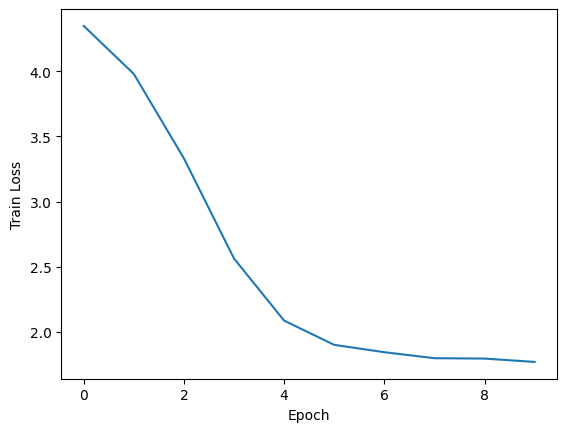

In [14]:
import matplotlib.pyplot as plt

def plot_history(loss_list):

  plt.plot(loss_list)
  plt.ylabel("Train Loss")
  plt.xlabel("Epoch")
  plt.show()

plot_history(loss_list)

---
## Avaliação Final do Modelo

Concluído o treinamento da rede neural, procedemos à sua avaliação usando o conjunto de dados `test_dataset`. Note que o `DataLoader` está sendo utilizado e o parâmetro `batch_size=len(test_dataset)` indica que todo o conjunto de teste está sendo retornado para as variáveis `xx_test` e `yy_test`.

Em seguida, invocamos o modelo, passando o conjunto de teste `xx_test`, não sem antes enviá-lo para o contexto correto de execução. Em seguida, o retorno da predição é arredondado ( `round()`) e armazenado na variável `yy_pred`.

Por fim, calculamos a acurácia geral do modelo, que nos informa uma proporção de previsões corretas sobre o total de previsões. Com uma acurácia de aproximadamente 88%, podemos concluir que o modelo é bastante eficaz.

In [15]:
from sklearn.metrics import accuracy_score

xx_test, yy_test = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset))))

yy_pred = model(xx_test.to(device)).round()

print('Acuracidade: ', accuracy_score(yy_test.detach().cpu().numpy(), yy_pred.detach().cpu().numpy()))

Acuracidade:  0.9054178145087236


## Adicionando a Regularização L2

Apesar da boa eficácia do modelo, em torno de 88%, ainda é possível explorar outras técnicas para obter melhores resultados. Neste exemplo, utilizaremos a Regularização L2, disponibilizada pelo parâmetro `weight_decay` da função de otimização. O valor `0.001` foi definido empiricamente.

Em seguida, treinamentos novamente o modelo com os mesmos parâmetros do treinamento anterior e avaliamos os resultados.

In [16]:
model = MLP(train_dataset.X.shape[1]).to(device)
loss_fn = nn.BCELoss()

# weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
optimizer = Adam(model.parameters(),  weight_decay=0.001, lr=0.001)

print(model)

MLP(
  (hidden1): Linear(in_features=16, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=4, out_features=1, bias=True)
  (act3): Sigmoid()
)


In [17]:
import numpy as np

EPOCHS = 10
loss_list = np.zeros((EPOCHS,))

for epoch in range(EPOCHS):
    loss_batch = 0

    for x_batch, y_batch in train:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # compute the model output
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss_batch + loss.item()

    loss_list[epoch] = loss_batch / len(x_batch)

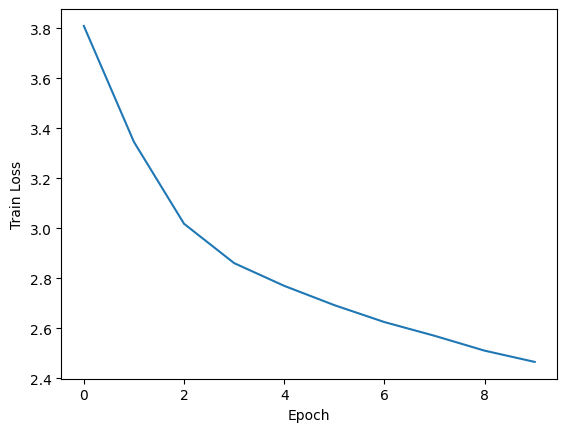

In [18]:
plot_history(loss_list)

In [19]:
test = DataLoader(test_dataset, batch_size=len(test_dataset))
xx_test, yy_test = next(iter(test))
yy_pred = model(xx_test.to(device)).round()

A acurácia em torno de 88% demonstra que a técnica de Regularização L2 não foi eficaz em aprimorar a acuracidade do modelo.

In [20]:
print(accuracy_score(yy_test.detach().cpu().numpy(), yy_pred.detach().cpu().numpy()))

0.8861340679522498


---
## Conclusões

Ao finalizar a análise e modelagem do conjunto de dados, concluímos que as redes neurais, com o uso do PyTorch, demonstraram ser ferramentas eficazes para prever a evasão e o sucesso acadêmico de estudantes.

A aplicação de técnicas como normalização e PCA e contribuíram significativamente para a eficácia do modelo.

A precisão alcançada, em torno de 88%, sugere que o modelo pode ser uma ferramenta valiosa para identificar estudantes em risco, permitindo intervenções proativas para melhorar a retenção e o sucesso acadêmico.

---
## Referências

1. University of California, Irvine. Predict Student's Dropout and Academic Success. UCI Machine Learning Repository. Disponível em: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success. Acesso em: 23 nov.2023.

2. Pierian Training. Machine Learning in Python: Principal Component Analysis (PCA). Disponível em: https://pieriantraining.com/machine-learning-in-python-principal-component-analysis-pca/. Acesso em: 23 nov.2023.

3. Tantai, Hengtao. “Improving Control and Reproducibility of PyTorch DataLoader with Sampler Instead of Shuffle Argument.” Medium, 22 fev. 2023. Disponível em: https://medium.com/@zergtant/improving-control-and-reproducibility-of-pytorch-dataloader-with-sampler-instead-of-shuffle-7f795490256e. Acesso em: 25 nov. 2023.

4. PyTorch. torch.optim.Adam. Disponível em: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html. Acesso em: 25 nov.2023.